## 3.1 每周普通汽油价格

In [1]:
da <- read.table("data/w-petroprice.txt", header = T)
da1 <- read.table("data/w-gasoline.txt")
dim(da)
head(da)
dim(da1)
head(da1)

[1] 717   5

Mon,Day,Year,World,US
1,3,1997,23.18,22.90
1,10,1997,23.84,23.56
1,17,1997,22.99,22.79
1,24,1997,22.05,21.83
1,31,1997,21.87,21.16
2,7,1997,21.56,20.97


[1] 717   1

V1
1.225
1.241
1.241
1.238
1.236
1.234


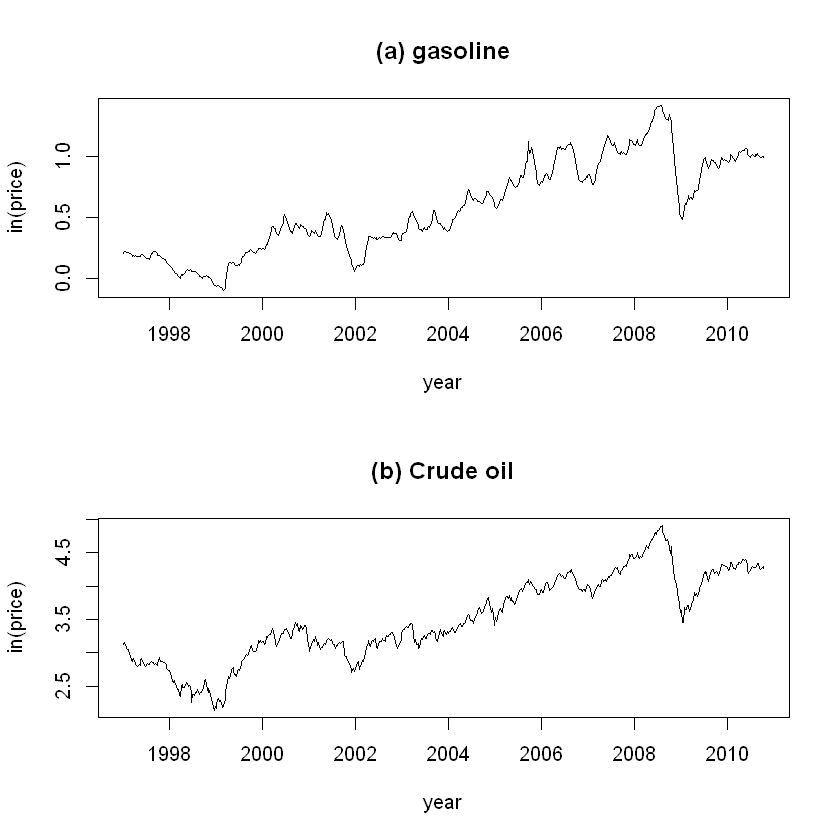

In [2]:
pgs <- log(da1[, 1])  # 汽油的价格
pus <- log(da$US)  # 原油的价格
tdx <- c(1:717)/52 + 1997  # 时间序列
par(mfcol = c(2, 1))
plot(tdx, pgs, xlab = "year", ylab = "in(price)", type = "l")
title(main = "(a) gasoline")
plot(tdx, pus, xlab = "year", ylab = "in(price)", type = "l")
title(main = "(b) Crude oil")

上图显示了美国普通汽油价格和原油周对数价格的时序图。如预期一样，这两种价格高度相关，同向运动，其对数价格也呈现出递增的趋势。

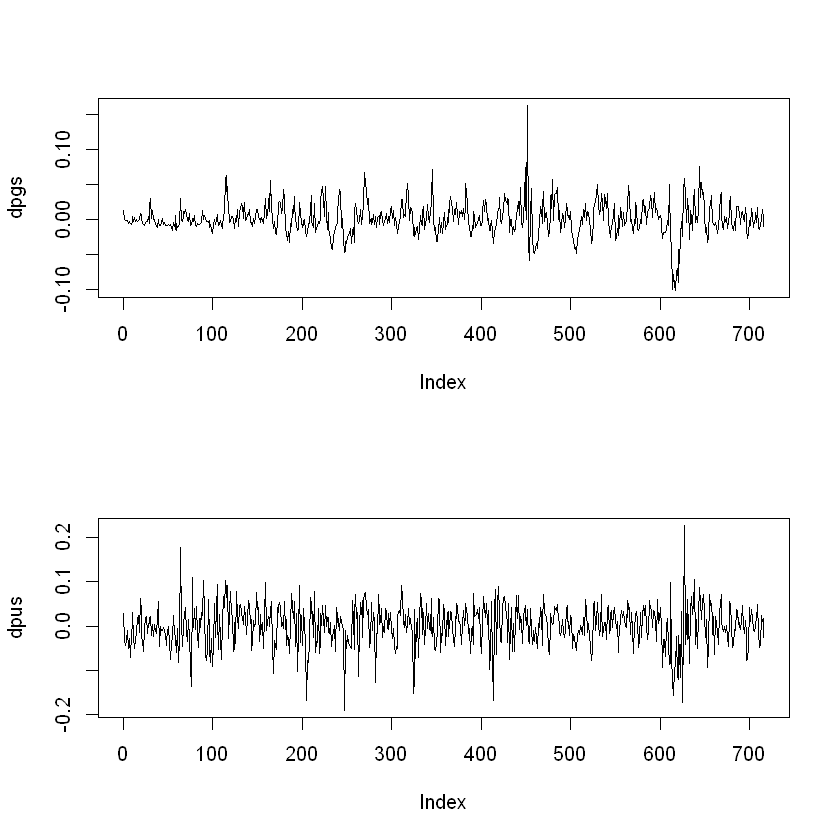

In [3]:
dpgs <- diff(pgs)  # 汽油价格的差分
dpus <- diff(pus)
par(mfcol = c(2, 1))
plot(dpgs, type = "l")
plot(dpus, type = "l")

由上图我们可以得知，使用一阶差分对数据进行处理后可以初步消除数据的趋势。

### 3.1.1 纯时间序列模型       
设$x_t$为美国周普通汽油价格的增长率。

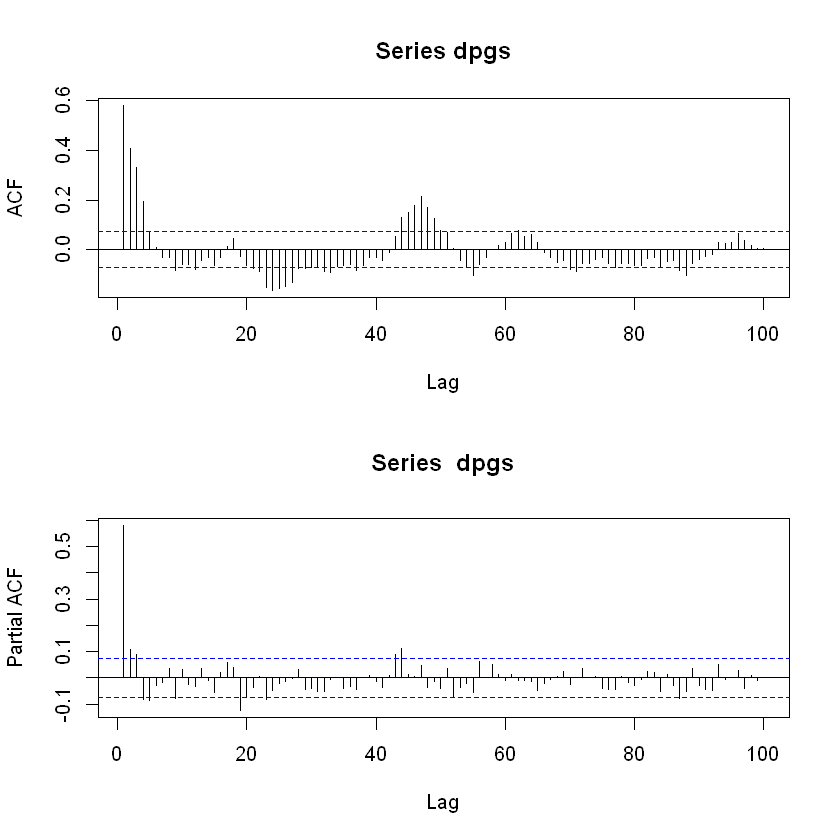

In [41]:
par(mfcol = c(2, 1))
acf(dpgs, lag = 100)
pacf(dpgs, lag = 100)

由$x_t$的样本自相关函数图和偏自相关函数图可见其自相关和偏自相关衰减得很快，这证明了该序列是平稳的。偏自相关函数在前5阶滞后时显著异于0。可选择AR模型。

In [5]:
m1 <- ar(diff(pgs), method = "mle")
m1$order

[1] 5

ar命令也选择了AR(5)模型。

In [6]:
t.test(dpgs)


	One Sample t-test

data:  dpgs
t = 1.3062, df = 715, p-value = 0.1919
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.0005536374  0.0027549956
sample estimates:
  mean of x 
0.001100679 


我们对序列$x_t$做单样本的t检验，其p-value=0.1919，表明该增长率的均值不是显著异于0的。

In [7]:
m1 <- arima(dpgs, order = c(5, 0, 0), include.mean = F)
m1


Call:
arima(x = dpgs, order = c(5, 0, 0), include.mean = F)

Coefficients:
         ar1     ar2     ar3      ar4      ar5
      0.5073  0.0788  0.1355  -0.0360  -0.0862
s.e.  0.0372  0.0417  0.0415   0.0417   0.0372

sigma^2 estimated as 0.0003262:  log likelihood = 1857.85,  aic = -3703.71

In [8]:
m1 <- arima(dpgs, order = c(5, 0, 0), include.mean = F, fixed = c(NA, NA, NA, 0, NA), transform.pars = F)
m1


Call:
arima(x = dpgs, order = c(5, 0, 0), include.mean = F, transform.pars = F, fixed = c(NA, 
    NA, NA, 0, NA))

Coefficients:
         ar1     ar2     ar3  ar4      ar5
      0.5036  0.0789  0.1220    0  -0.1009
s.e.  0.0370  0.0418  0.0385    0   0.0330

sigma^2 estimated as 0.0003265:  log likelihood = 1857.48,  aic = -3704.96

由于4阶滞后系数的t比小于1，其系数不显著。我们改进的模型如下：
$$
(1-0.5036B-0.0789B^2-0.1220B^3+0.1009^5)X_t=a_t
$$

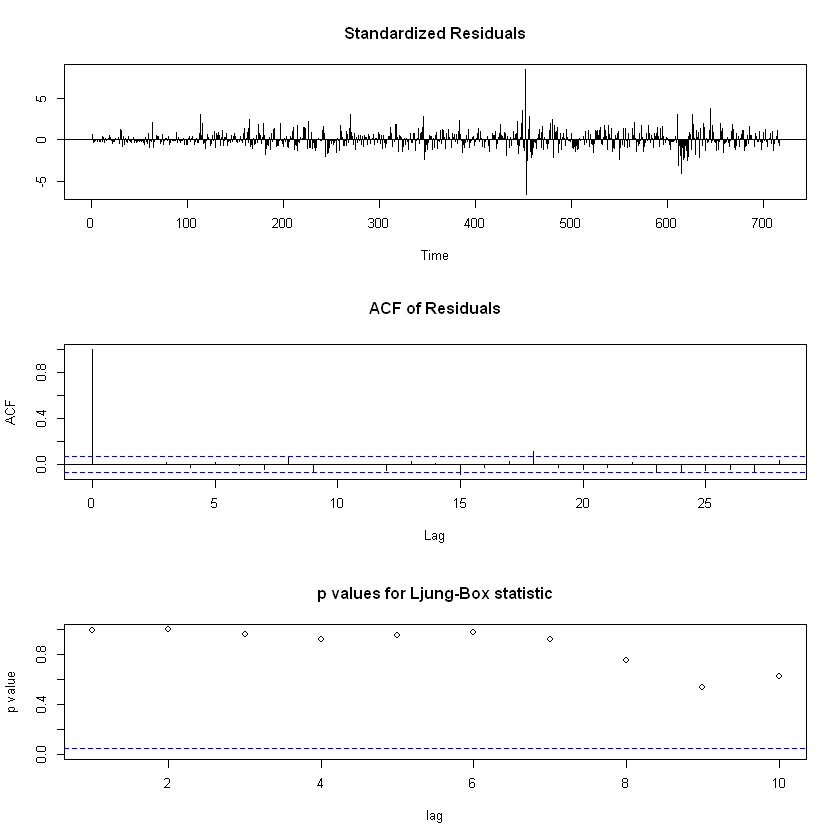

In [9]:
tsdiag(m1, gol = 20)

In [10]:
Box.test(m1$residuals, lag=5, type='Ljung')


	Box-Ljung test

data:  m1$residuals
X-squared = 1.109, df = 5, p-value = 0.9533


In [11]:
library(TSA)
eacf(dpgs, 6, 12)


Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar



AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12
0 x x x x o o o o x o o  x  o 
1 x x x x o o o o x o o  o  o 
2 x x x o o o o o x o o  o  o 
3 x x x x o o o o x o o  o  o 
4 x x x x o o o o o o o  o  o 
5 x o x o o o x o o o o  o  o 
6 x o o o x o o x o o o  o  o 


<span class="mark">书上之前使用了6和12这两个参数，但不知道是如何取的。   
我通过eacf命令拟合出来的是ARMA(2, 3)模型，但书上用的是ARMA(1, 3)模型。</span>

In [12]:
m2 <- arima(dpgs, order = c(0, 0, 5), include.mean = F)
m2
m2 <- arima(dpgs, order = c(0, 0, 5))
m2


Call:
arima(x = dpgs, order = c(0, 0, 5), include.mean = F)

Coefficients:
         ma1     ma2     ma3     ma4    ma5
      0.5033  0.3245  0.3291  0.2108  0.062
s.e.  0.0371  0.0413  0.0387  0.0377  0.039

sigma^2 estimated as 0.000327:  log likelihood = 1856.89,  aic = -3703.77


Call:
arima(x = dpgs, order = c(0, 0, 5))

Coefficients:
         ma1     ma2     ma3     ma4     ma5  intercept
      0.5028  0.3238  0.3284  0.2102  0.0615     0.0011
s.e.  0.0371  0.0413  0.0387  0.0377  0.0390     0.0016

sigma^2 estimated as 0.0003268:  log likelihood = 1857.11,  aic = -3702.22

<span class="mark">可不可以使用MA模型，需不需要加include.mean=F，系数该如何检验，看t比吗？</span>

### 3.1.2 原油价格的使用
由于汽油价格高度依赖于原油的现货价格，我们使用一个具有时间序列误差的回归模型来提高汽油价格的预测精度。         
假设$z_t$为周原油价格增长率。

In [13]:
m3 <- lm(dpgs ~ dpus)
summary(m3)


Call:
lm(formula = dpgs ~ dpus)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.076840 -0.009456 -0.000279  0.008804  0.150721 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0006472  0.0006876   0.941    0.347    
dpus        0.2865347  0.0150791  19.002   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01839 on 714 degrees of freedom
Multiple R-squared:  0.3359,	Adjusted R-squared:  0.3349 
F-statistic: 361.1 on 1 and 714 DF,  p-value: < 2.2e-16


由于截距项p-value=0.347>0.05，截距项为0的原假设被接受，所以我们要重新拟合一个截距项为0的线性模型。

In [14]:
m3 <- lm(dpgs ~ -1 + dpus)  # 表示回归模型没有常数项
summary(m3)


Call:
lm(formula = dpgs ~ -1 + dpus)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.076149 -0.008834  0.000365  0.009441  0.151350 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
dpus  0.28703    0.01507   19.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01839 on 715 degrees of freedom
Multiple R-squared:  0.3366,	Adjusted R-squared:  0.3357 
F-statistic: 362.8 on 1 and 715 DF,  p-value: < 2.2e-16


简单线性回归模型为:        
$$
x_t=0.287z_t+\varepsilon_t
$$

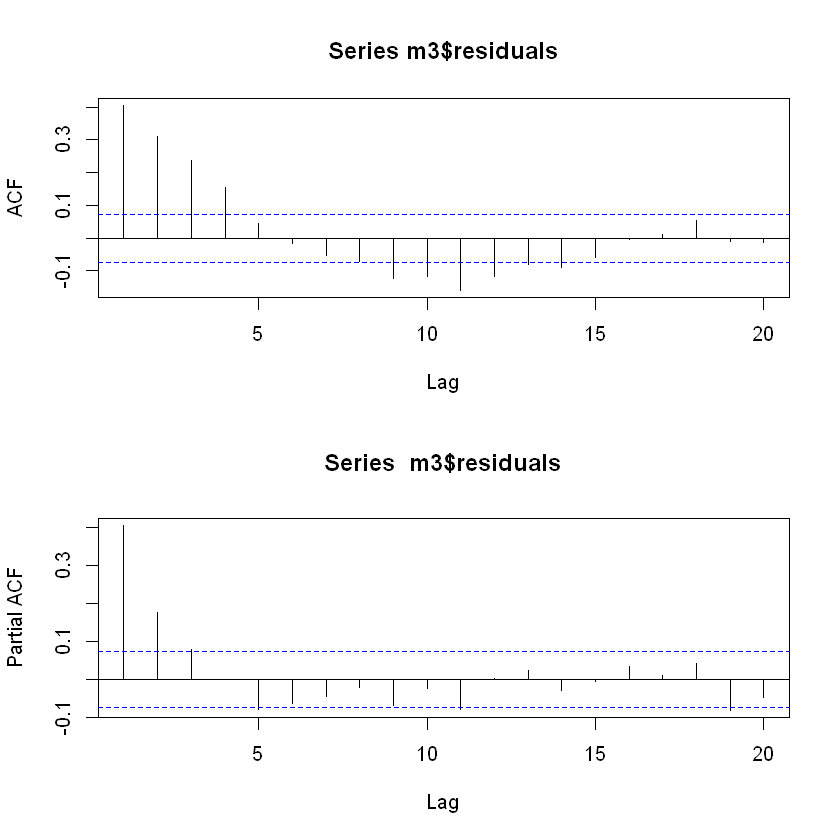

In [15]:
par(mfcol = c(2, 1))
acf(m3$residuals, lag = 20)
pacf(m3$residuals, lag = 20)

<span class="mark">由于残差$\varepsilon_t$的样本自相关和偏自相关函数与$x_t$相似，所以$z_t$的使用不能改变$x_t$模型的假定。</span>

In [16]:
m4 <- ar(m3$residuals, method = "mle")
m4$order

[1] 6

In [17]:
m4 <- arima(dpgs, order = c(6, 0, 0), include.mean = F, xreg = dpus)
m4


Call:
arima(x = dpgs, order = c(6, 0, 0), xreg = dpus, include.mean = F)

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ar6    xreg
      0.3953  0.1634  0.0946  0.0297  -0.0873  -0.0525  0.1927
s.e.  0.0389  0.0400  0.0404  0.0405   0.0400   0.0373  0.0136

sigma^2 estimated as 0.0002524:  log likelihood = 1949.61,  aic = -3885.21

ar命令对残差$\varepsilon_t$设定了一个AR(6)模型。模型为
$$
(1-0.40B-0.16B^2-0.09B^3-0.03B^4+0.09B^5+0.05B^6)(x_t-0.193z_t)=a_t
$$           
<span class="mark">在5%水平下，4阶滞后和6阶滞后的系数不显著。           
下面的模型是直接拟合了一个AR(5)模型，我觉得可以将4阶滞后和6阶滞后的系数去掉，仍然使用AR(6)模型。</span>

In [18]:
m4 <- arima(dpgs, order = c(5, 0, 0), include.mean = F, xreg = dpus)
m4


Call:
arima(x = dpgs, order = c(5, 0, 0), xreg = dpus, include.mean = F)

Coefficients:
         ar1     ar2     ar3     ar4      ar5    xreg
      0.4022  0.1621  0.0899  0.0209  -0.1086  0.1914
s.e.  0.0387  0.0401  0.0403  0.0400   0.0371  0.0136

sigma^2 estimated as 0.0002531:  log likelihood = 1948.62,  aic = -3885.23

In [19]:
m4 <- arima(dpgs, order = c(5, 0, 0), include.mean = F, xreg = dpus, fixed = c(NA, NA, NA, 0, NA, NA), 
            transform.pars = F)
m4


Call:
arima(x = dpgs, order = c(5, 0, 0), xreg = dpus, include.mean = F, transform.pars = F, 
    fixed = c(NA, NA, NA, 0, NA, NA))

Coefficients:
         ar1     ar2     ar3  ar4      ar5    xreg
      0.4037  0.1642  0.0961    0  -0.1014  0.1911
s.e.  0.0386  0.0399  0.0386    0   0.0345  0.0136

sigma^2 estimated as 0.0002532:  log likelihood = 1948.48,  aic = -3886.95

拟合的模型为：
$$
(1-0.404B-0.164B^2-0.096B^3+0.101B^5)(x_t-0.191z_t)=a_t
$$

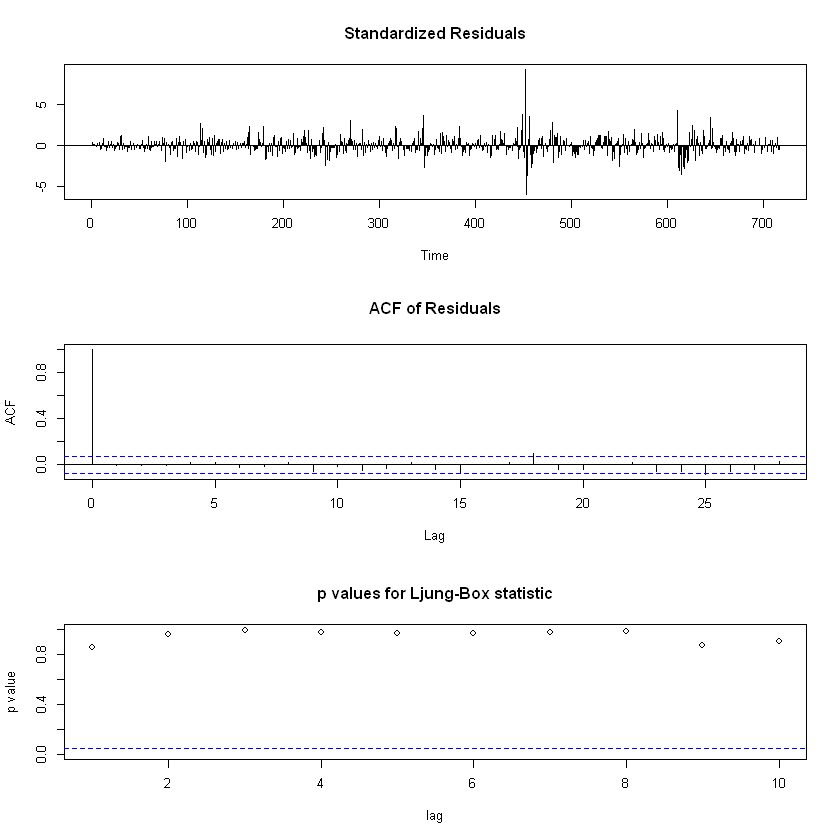

In [20]:
tsdiag(m4, gol = 20)

In [21]:
Box.test(m4$residuals, lag = 6, type = "Ljung")


	Box-Ljung test

data:  m4$residuals
X-squared = 1.3176, df = 6, p-value = 0.9707


Ljung-Box检验证明模型是显著的。

### 3.1.3 应用滞后期的原油价格数据
为了加大预测的超前时间，这里我们使用原油价格增长率的滞后项。假设模型为
$$
x_t=\beta z_{t-1} + \varepsilon_t
$$

In [22]:
m6 <- lm(dpgs[2:716] ~ dpus[1:715])
summary(m6)


Call:
lm(formula = dpgs[2:716] ~ dpus[1:715])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08914 -0.01198 -0.00083  0.01063  0.16090 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0007842  0.0007834   1.001    0.317    
dpus[1:715] 0.1849889  0.0171724  10.772   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02093 on 713 degrees of freedom
Multiple R-squared:   0.14,	Adjusted R-squared:  0.1388 
F-statistic:   116 on 1 and 713 DF,  p-value: < 2.2e-16


In [23]:
m6 <- lm(dpgs[2:716] ~ -1 + dpus[1:715])
summary(m6)


Call:
lm(formula = dpgs[2:716] ~ -1 + dpus[1:715])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.088318 -0.011145 -0.000011  0.011391  0.161679 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
dpus[1:715]  0.18560    0.01716   10.81   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02093 on 714 degrees of freedom
Multiple R-squared:  0.1408,	Adjusted R-squared:  0.1395 
F-statistic:   117 on 1 and 714 DF,  p-value: < 2.2e-16


拟合的模型为
$$
x_t=0.186z_{t-1}+\varepsilon_t
$$

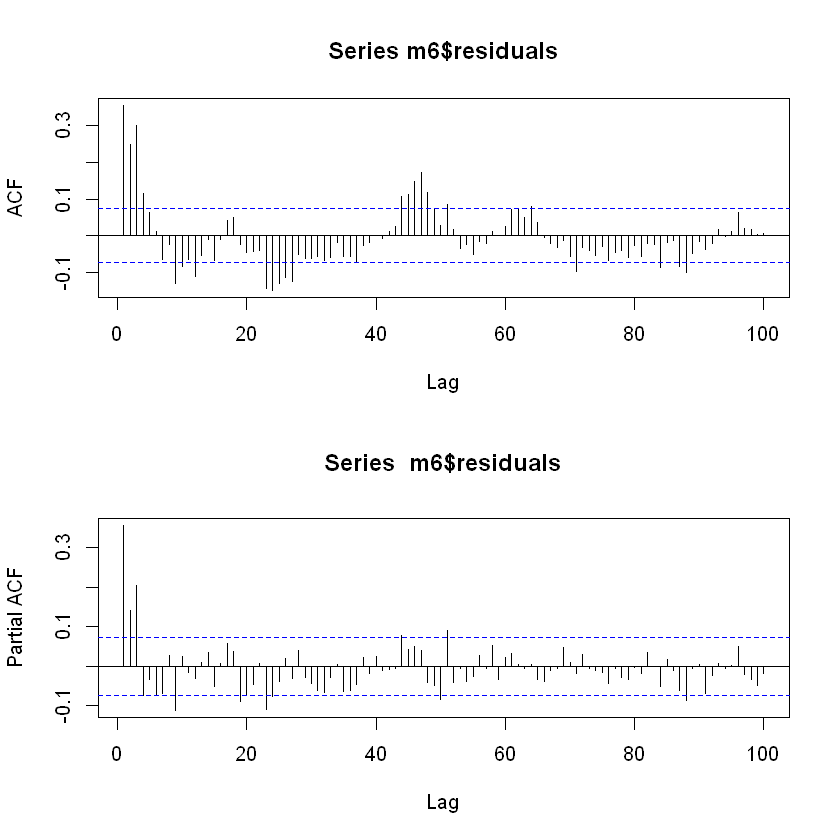

In [24]:
par(mfcol = c(2, 1))
acf(m6$residuals, lag = 100)
pacf(m6$residuals, lag = 100)

In [25]:
m7 <- ar(m6$residuals, method = "mle")
m7$order

[1] 9

In [26]:
m7 <- arima(dpgs[2:716], order = c(9, 0, 0), include.mean = F, xreg = dpus[1:715])
m7


Call:
arima(x = dpgs[2:716], order = c(9, 0, 0), xreg = dpus[1:715], include.mean = F)

Coefficients:
         ar1     ar2     ar3      ar4      ar5      ar6      ar7     ar8
      0.4559  0.0888  0.1679  -0.0468  -0.0653  -0.0195  -0.0362  0.0797
s.e.  0.0425  0.0410  0.0423   0.0415   0.0416   0.0414   0.0410  0.0408
          ar9    xreg
      -0.0882  0.0454
s.e.   0.0373  0.0174

sigma^2 estimated as 0.0003204:  log likelihood = 1861.55,  aic = -3703.1

<span class="mark">我觉得5阶滞后系数应该为0，而不是8阶滞后系数。</span>

In [27]:
m7 <- arima(dpgs[2:716], order = c(9, 0, 0), include.mean = F, xreg = dpus[1:715], 
    fixed = c(NA, NA, NA, 0, NA, 0, 0, 0, NA, NA), transform.pars = F)
m7


Call:
arima(x = dpgs[2:716], order = c(9, 0, 0), xreg = dpus[1:715], include.mean = F, 
    transform.pars = F, fixed = c(NA, NA, NA, 0, NA, 0, 0, 0, NA, NA))

Coefficients:
         ar1     ar2     ar3  ar4      ar5  ar6  ar7  ar8      ar9    xreg
      0.4544  0.0877  0.1415    0  -0.0830    0    0    0  -0.0640  0.0406
s.e.  0.0427  0.0413  0.0393    0   0.0345    0    0    0   0.0318  0.0176

sigma^2 estimated as 0.000323:  log likelihood = 1858.7,  aic = -3705.4

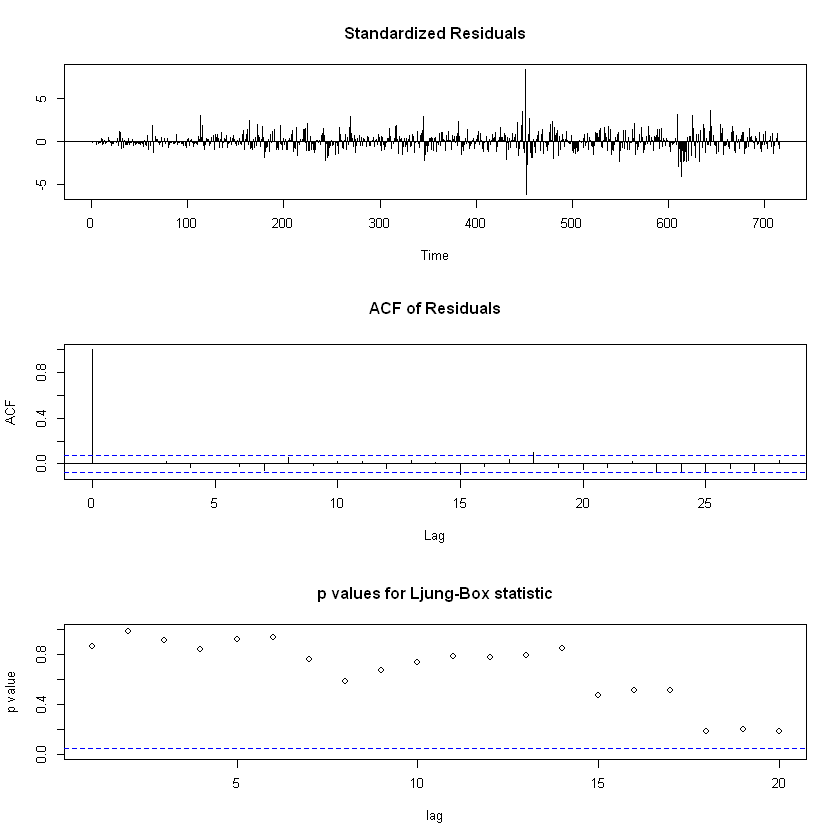

In [28]:
tsdiag(m7, gof = 20)

### 3.1.4 样本外预测
回测检验方法将数据分为建模和预测两个子样本，利用迭代计算预测值。两个经常使用的衡量预测精度的度量是预测误差的均方根(Root Mean Square of Forecast Error, RMSFE)和平均绝对预测误差(Mean Absolute Forecast Error, MAFE)。

In [38]:
source("backtest.R")
pm1 <- backtest(m1, dpgs, 316, 1, fixed = c(NA, NA, NA, 0, NA), inc.mean = F)

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

[1] "RMSE of out-of-sample forecasts"
[1] 0.02171235
[1] "Mean absolute error of out-of-sample forecasts"
[1] 0.01537881


In [30]:
pm4 <- backtest(m4, dpgs, 316, 1, xre = dpus, inc.mean = F, fixed = c(NA, NA, NA, 
    0, NA, NA))

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"some AR parameters were fixed: setting transform.pars = FALSE"Warning message in 

[1] "RMSE of out-of-sample forecasts"
[1] 0.01925732
[1] "Mean absolute error of out-of-sample forecasts"
[1] 0.01285104


In [31]:
pm7 <- backtest(m7, dpgs[2, 716], 315, 1, xre = dpus[1:715], inc.mean = F, fixed = c(NA, 
    NA, NA, 0, NA, 0, 0, 0, NA, NA))

ERROR: Error in dpgs[2, 716]: 量度数目不对
